In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from packages.rl import env_hhb
from packages.z_sampling.real_xy_sample import generate_gaussian_real_points

In [32]:
def plot_2D_potential_Virasoro(
    central_charge: float,      # c_val
    bounds_hext: list,          # [hext_min, hext_max]
    bounds_hint: list,          # [hint_min, hint_max]
    N_lsq=20,
    kmax=2,
    n_states_rew=2,
    kmax1=10,
    device="cuda",
    dtype=torch.float64,
    contour_std=0.1
):
    """
    在 (d1, d3) 平面上绘制 Virasoro 最小二乘 reward 的等高线图。
    假设 N_state=1，只画 h=hb=d3 的 slice，h_ext=0 固定。
    """

    device = torch.device(device)
    # 1) 网格
    nx, ny = 200, 200
    hext_range = np.linspace(bounds_hext[0], bounds_hext[1], nx)
    hint_range = np.linspace(bounds_hint[0], bounds_hint[1], ny)
    Xg, Yg = np.meshgrid(hext_range, hint_range, indexing="xy")  # shape (ny, nx)

    # 2) 扁平化
    pts = torch.from_numpy(np.stack([Xg.ravel(), Yg.ravel()], 1)).to(device=device, dtype=dtype)
    z, zbar = generate_gaussian_real_points(400, std=contour_std, device=device)

    h_ext_vals = pts[:, 0]
    h_int_vals = pts[:, 1].unsqueeze(1)
    hb_int_vals  = pts[:, 1].unsqueeze(1)
    c_vals = torch.tensor([central_charge - 1e-5] * pts.shape[0], device=device, dtype=dtype)
    
    Rf, _, _ = env_hhb.least_sq_std_rew_Virasoro(
                h_int_vals, hb_int_vals, h_ext_vals,
                z, zbar,
                c_vals, 
                N_lsq=N_lsq, kmax=kmax, n_states_rew=n_states_rew,
                kmax1=kmax1, device="cuda", analytic_H=False
            )
    Rg = Rf.cpu().numpy().reshape(nx,ny)

    fig, ax = plt.subplots(figsize=(6,6))
    cf = ax.contourf(Xg, Yg, Rg, levels=50, cmap="viridis")
    ax.set_xlabel("h_ext")      # x 轴
    ax.set_ylabel("h_int = hb") # y 轴
    ax.set_title("Vir. Least‐Sq Reward on (h_ext, h_int) Plane")

    fig.colorbar(cf, label="reward")
    plt.tight_layout()
    plt.grid()
    plt.show()


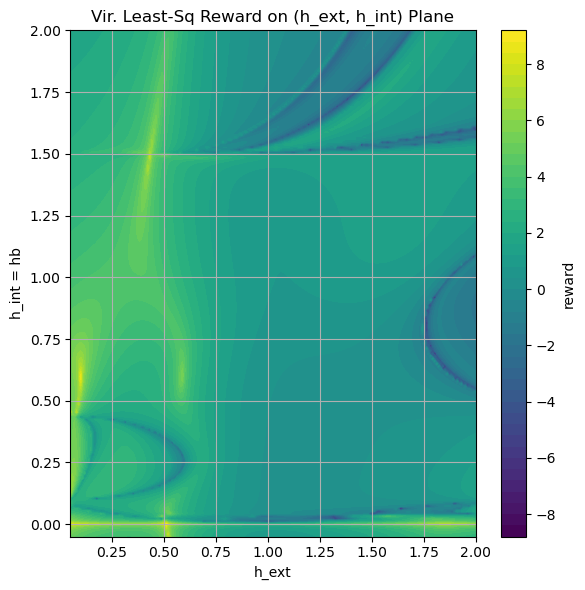

In [39]:
central_charge = 7/10
bounds_hext = [1/20, 2]
bounds_hint = [-1/20, 2]
plot_2D_potential_Virasoro(central_charge=central_charge, bounds_hext=bounds_hext, bounds_hint=bounds_hint)